In [1]:
import sys
sys.path.append("../")
from models.path_estimators.normal import NormalPathEstimator
from utils import unzip, ProgressBar
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
%matplotlib inline

### One dimensional path sampling
Suppose we have a family of distributions $p(x \;|\; \theta)$ for $\theta \in \Theta \subset \mathcal{R}$. For two distributions indexed by $\theta_0, \theta_1 \in \Theta$ we are interested in computing the log-ratio of normalizing constants

$$ \lambda = \log(z_1) - \log(z_0)$$

One way to do this is to specify a path, a continuously differentiable function $\theta(t):[0,1]\rightarrow \Theta$ with $\theta(0) = \theta_0$ and $\theta(1) = \theta_1$. Having specified the path, the thermodynamic integral holds

$$\lambda = \int_0^1 \dot\theta(t) \cdot  E_{\theta(t)} \Big( \frac{d}{d\theta}\log q\big(x\;\big|\;\theta(t)\big)\Big)dt$$

Often times the expectation is called the potential and we write

$$ U(x, \theta) = \frac{d}{d\theta}\log q(x\;|\;\theta)$$

This gives the following thermodynamic integral

$$ \lambda = \int_0^1 \dot\theta(t) \cdot  E_{\theta(t)} U\big(x, \theta(t)\big)dt $$ 

In practice we choose a $\theta(t)$ and sample from $x\;|\;\theta(t)$ on a grid of $t_j$-values, $j=0,...,J$. For simplicity we write $\theta_j = \theta(t_j)$. At each of these values we estimate $E_{\theta_j} U\big(x, \theta_j\big)$ with the sample average $\bar U(\theta_j)$ and approxiamte the thermodynamic integral using the trapezoidal rule.

$$ \hat\lambda = \frac{1}{2}\sum \frac{\theta_{j+1} - \theta_j}{2} \Big( \bar{U}\big(\theta_{j+1}\big) +  \bar{U}\big(\theta_j\big)\Big) $$

### Multidimensial path sampling
A similar story, but this time $\Theta \subset \mathcal{R}^D$. The path becomes a curve with a derivative $\dot{\theta}_d$ for each dimension and a collection of potentials

$$ U_d(x, \theta) = \frac{d}{d\theta_d}\log q\big(x\;\big|\;\theta\big)$$

The thermodynamic integral is written

$$ \lambda = \int_0^1  \sum_{d=1}^D \dot\theta_d(t) \cdot  E_{\theta(t)} U_d\big(\theta(t)\big)dt $$

With analgous appriximation via the trapezoid method

### Goal of the project
The goal of this project is to find a curve in $\mathcal{R}^D$ that minimizes the variance of the thermodynamic estimator. The asymptotic variance (in $J$ and $N$) is 

$$ \text{Var}(\hat\lambda) +\lambda^2 = \frac{1}{N}\int_0^1  \sum_{c, d=1}^D \dot\theta_c(t) \dot\theta_d(t) \cdot  E_{\theta(t)} \Big(U_c\big(x, \theta(t)\big) U_d\big(x, \theta(t)\big)\Big)dt $$

In practice we approximate this curve by choosing a discrete set of points $\{(\theta_{j}^1,...,\theta_{j}^D)\}_{j=0}^{J}$. Let $\Delta_{j}^d = \theta_{j+1}^d - \theta_{j}^d$ be the dimension-wise difference between subsequent points and $\bar{U}_{c,d}(\theta_j)$. The variance of this discrete approximation is given by

$$ \text{Var}(\hat\lambda) = \frac{1}{N} \sum_{j=1}^{J} \sum_{c,d=1}^D \Delta_j^{c} \Delta_j^{d} \cdot \frac{\text{Var}\Big(\bar{U}_{c,d}(\theta_j)\Big)+\text{Var}\Big(\bar{U}_{c,d}(\theta_{j-1})\Big)}{4}$$

My approach to reducing the variance is

1) Estimate $\text{Var}\Big(\bar{U}_{c,d}(\theta_{j})\Big)$ at a prespecified set of design points. 

2) Fit a GP along each pairwise dimension combination to interpolate the variance/learn the energy manifold

3) Use a weighted, directed, acyclic graph to approximate the collection of paths from $\theta_0$ to $\theta_1$

4) Find the best path using topological sorting


## Normal Example
- Spherical normal distribution in 10 dimensions
- Move from $N(0, 1)$ to $N(100, 1)$
- Geometric Tempered Path
$$ p(x \;|\; \beta, t) \propto \text{N}(x\,;\, 0, 1)^{(1-\beta)*t} \cdot \text{N}(x\,;\, 100, 1)^{\beta*t}$$

In [2]:
dim = 10 # Settings that work
D = 100
mean1 = np.zeros(dim); mean2 = mean1 + D
covariance1, covariance2 = np.eye(dim), np.eye(dim)
npe = NormalPathEstimator(mean1, mean2, covariance1, covariance2,path_sampler_kwargs={'min_temp':0.1})

Loading Stan model...


## Estimate the energy
- Estimate variance of estimator on a 6 x 6 grid of $(\beta, t)$ combinations
- Used 500 samples per point 
- 18,000 samples total

In [3]:
npe.fit_energy_map(500, 6, 6, verbose=False)

## Interpolate the energy manifold
- Fit an independent GP to each dimension-pair 
- Used a double exponential covariance kernel
- This is a visualization of fitted curve (in each dimension)
- Estimated variance on a grid of 101x101 points 

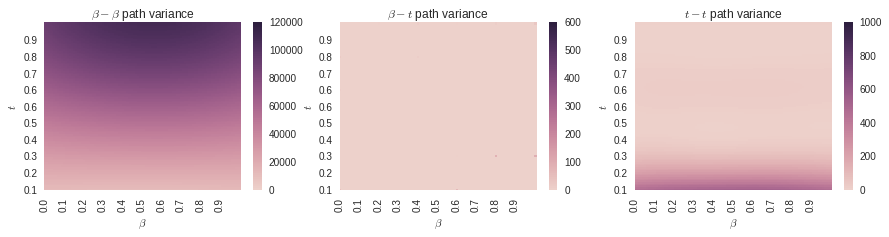

In [4]:
plot_kwargs=[{'vmax':i, 'vmin':j} for i, j in zip([1.2e5, 600, 10**3], [0,0,0])]
#plot_kwargs = [{}]*3
npe.plot_energy_map(plot_kwargs)

## Estimated 'true' manifold
- Estimated variance at each of the interpolated points
- Used $10^4$ independent samples for each estimate

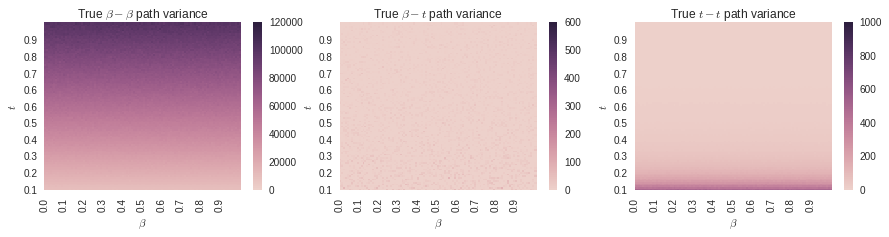

In [5]:
plot_kwargs=[{'vmax':i, 'vmin':j} for i, j in zip([1.2e5, 600, 10**3], [0,0,0])]
# plot_kwargs = [{}]*3
npe.plot_true_energy_map(N=10**4, plot_kwargs=plot_kwargs)

## Construct a DAG
- 30 x 30 grid of path locations (vertices) evenly spaced along each axis
- Created edges between pairs of vertices that were within 10 moves of each other
- Allowed temperature to move up/down, forced $\beta$ to always increase (at least 1 increment)

In [6]:
grid_sizes = [50, 50]
directions = ['forward', 'both']
max_strides= [20,20]
npe.generate_weighted_graph(grid_sizes, directions, max_strides, offset=0)

## Find the shortest path
- Weighted each edge by the variance of the thermodynamic estimator
- Found the shortest path using topoligical sorting + shortest path algorithm $\mathcal{O}(E+V)$

In [24]:
# npe.set_offset(1.0)
uniform_path = npe.uniform_path(2)
weighted_path = npe.weighted_path(len(uniform_path))
linear_path = npe.linear_path(len(uniform_path))

- used a step cost of 1.0 (to make short steps less attractive)
- comparing best path to path computed using weighting

99


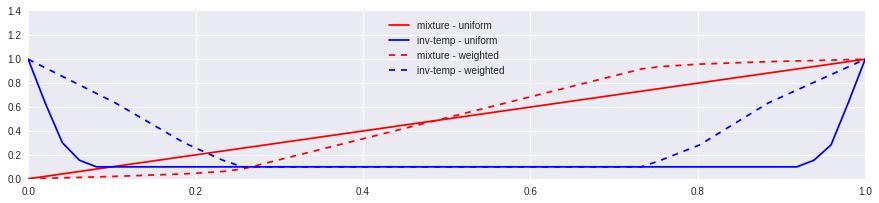

In [25]:
ts = np.linspace(0,1,len(uniform_path))
betas, temps = unzip(uniform_path)
plt.plot(ts, betas, color='red', label='mixture - uniform')
plt.plot(ts, temps, color='blue', label='inv-temp - uniform')
print len(uniform_path)

ts = np.linspace(0,1,len(weighted_path))
betas, temps = unzip(weighted_path)
plt.plot(ts, betas, color='red', ls='--', label='mixture - weighted')
plt.plot(ts, temps, color='blue', ls='--', label='inv-temp - weighted')
plt.legend(loc='upper center')
plt.ylim(0,1.4)
plt.show()

## Estimate $\lambda$
- Did 50 experiments using three different paths
- The best path, the weighted best path, and the linear path (standard)
- Each path had a length of 300
- 100 samples at each step

In [28]:
n_estimates = 50
n_samples = 100

In [29]:
uniform_residuals = []
pb = ProgressBar(n_estimates)

for n in range(n_estimates):
    lambda_hat = npe.estimate_lambda(uniform_path, n_samples, verbose=False)
    uniform_residuals.append(lambda_hat-npe.true_lambda())
    pb.increment()
    
pb.finish()

% complete:  4 10 16 22 28 34 40 46 52 58 64 70 76 82 88 94 100 
Elapsed time: 1292.6 seconds.


In [30]:
weighted_residuals = []
pb = ProgressBar(n_estimates)

for n in range(n_estimates):
    lambda_hat = npe.estimate_lambda(weighted_path, n_samples, verbose=False)
    weighted_residuals.append(lambda_hat-npe.true_lambda())
    pb.increment()
    
pb.finish()

% complete:  4 10 16 22 28 34 40 46 52 58 64 70 76 82 88 94 100 
Elapsed time: 1105.3 seconds.


In [31]:
linear_residuals = []
pb = ProgressBar(n_estimates)

for n in range(n_estimates):
    lambda_hat = npe.estimate_lambda(linear_path, n_samples, verbose=False)
    linear_residuals.append(lambda_hat-npe.true_lambda())
    pb.increment()
    
pb.finish()

% complete:  4 10 16 22 28 34 40 46 52 58 64 70 76 82 88 94 100 
Elapsed time: 1246.4 seconds.


## Results
Best path, weighted best path, linear path

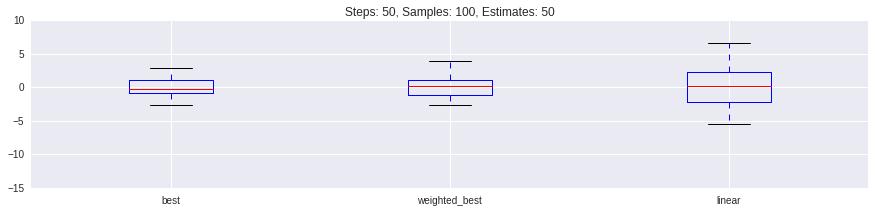

In [32]:
plt.boxplot([uniform_residuals, weighted_residuals, linear_residuals])
plt.xticks(range(1,4),['best', 'weighted_best', 'linear'])
plt.title('Steps: {}, Samples: {}, Estimates: {}'.format(50, 100, 50))
plt.show()